# Style Transfer

Neural style transfer, first introduced in the paper [_Image Style Transfer Using Convolutional Neural Networks_](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf), consists in combining together the style of an image with the content of another. The algorithm consists in using pre-trained convolutional layers (features) of the VGG19 CNN in order to combine the style and content of two images; the new image is generated by minimising simultaneously the content loss (difference between content image and new image features) and the style loss (difference between style image and new image features).

This notebook is based on the following resources:
1. [_Image Style Transfer Using Convolutional Neural Networks_](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
2. [_Texture Synthesis Using Convolutional NeuralNetworks_](https://arxiv.org/pdf/1505.07376.pdf)
3. [Udacity Deep Learning with Pytorch Course - Style Transfer](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/style-transfer)

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import models, transforms

In [2]:
import numpy as np

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
np.random.seed(42)
torch.manual_seed(42)

### Device

Style transfer is based on the VGG19 CNN architecture. VGG19 is a deep CNN and therefore a GPU is required to run style transfer in a reasonable time:

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Input

The style-transfer algorithm needs a content image and a style image as input. We can load such images using `PIL` and transform them into an input suitable for VGG19. The preparation steps are the following:

1. Load the image using `PIL`
2. Resize the image if it is too large (to reduce optimisation time)
3. Transform the image into a `torch.tensor`
4. Normalise the tensor (using VGG19 normalisation)
5. Remove alpha channel, if any
6. Add spurious batch dimension (for VGG19 compatibility)

In [6]:
from PIL import Image

def imgload(image, max_size=400, shape=None):
       
    # Load image
    img = Image.open(image).convert('RGB')
    
    # Select image size
    # User-defined shape or maximum size.
    if shape is not None:
        size = shape
    else:
        if max(img.size) > max_size:
            size = max_size
        else:
            size = max(img.size)
        
    transform = transforms.Compose(
        [
            transforms.Resize(size), # Resize image
            transforms.ToTensor(), # Convert to tensor
            transforms.Normalize( # Normalise (according to VGG19 training)
                (0.485, 0.456, 0.406), 
                (0.229, 0.224, 0.225))
        ]
    )

    # Discard alpha channel (channel 3), if any
    img = transform(img)[:3,:,:]
    
    # Add spurious batch dimension
    img = img.unsqueeze(0)
    
    return img

We can now load the style and content image and move them to the device:

In [7]:
content_path = "images/kilimanjaro.jpg"
style_path = "images/signac.jpg"

# Load content and style images
content = imgload(content_path)
style = imgload(style_path)

# Move images to device
content = content.to(device)
style = style.to(device)

Images are represented as normalised `torch.tensor` (with a spurious batch dimension) in order to be propagated trough VGG19 convolutional layers. For visualization we need to to make sure that the image data is on the CPU, is un-normalised and of the right shape for `plt.imshow`:

In [8]:
def img(tensor):
    """
    Transform tensor to image
    """
        
    # Create a copy of the original tensor
    # Detach from computational graph
    # Bring tensor to CPU
    # Transform to numpy array
    img = tensor.clone().detach().cpu().numpy()
    
    # Squeeze out spurious batch dimension
    img = img.squeeze()
    
    # Transpose image
    # From PyTorch (C, H, W) to numpy (H, W, C)
    img = img.transpose(1, 2, 0)
    
    # Un-normalize (using VGG19 normalization)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    
    # Avoid Matplotlib warning
    # Matplotlib clips RGB data to [0,1] automatically
    img = img.clip(0, 1)
    
    return img

We can finally visualize the content and style images:

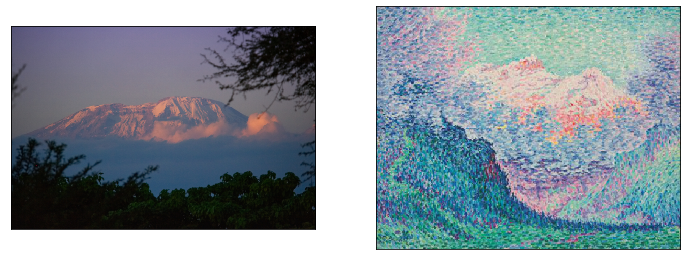

In [9]:
fig = plt.figure(figsize=(12,10))

# Display content image
ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(img(content))

# Display style image
ax2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax2.imshow(img(style))

plt.show()

## VGG19 Architecture

The original style transfer paper, [_Image Style Transfer Using Convolutional Neural Networks_](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf), is based on the [VGG19](https://arxiv.org/pdf/1409.1556.pdf) CNN architecture. Luckily, such architecture is available via `torchvision` as a pre-trained model.

In [10]:
VGG19 = models.vgg19(pretrained=True)
print(VGG19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

We see that the convolutional part of the CNN is contained in the `nn.Sequential` variable called `features`. Since we only need the pre-trained convolutional layers (and not the classifier) to compute image features, we can extract them in a simplified sequentual model:

In [11]:
vgg = VGG19.features

Since we want to keep the CNN layers as they are, we can freeze all their parameters so that they are not changed further during optimization:

In [12]:
for parameter in vgg.parameters():
    parameter.requires_grad_(False)

Finally, we can move everything to the device:

In [13]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

We see that the model has multiple convolutions between every max pooling layers. The usual naming convention for VGG19 goes as follows: `convI_J` is the convolution `I` before the `J` max pooling layer. However, in the PyTorch the different layers are simply numbered from 0 to 36.

### Features Extraction

A convolutional layer with $N_l$ convolutional filters outputs $N_l$ feature maps of dimension $M_l$ (width times height of the feature map). Therefore the output of a convolutional layer can be stored in a feature matrix $F^l \in \mathbb{R}^{N_l\times M_l}$, where $F_{ij}^l$ is the output at position $j$ of filter $i$ in layer $l$. We can easily extract such feature maps by propagatin an image through VGG19 and saving the output of the convolutional layers:

In [14]:
def getfeatures(image, model, layers):
    """
    Get model features (output of convolutional layers) for the given image.
    
    Layers are listed in a dictionary mapping PyTorch index to standard names.
    """
    
    features = {}
    
    # Rename input image to x
    # x will be propagated through the network
    x = image 
    
    # Loop over all layers (derived from nn.Model)
    # Name is the layer name, the index in nn.Sequential in this case
    for name, layer in model._modules.items():
        # Forward pass
        x = layer(x) 
        
        if name in layers:
            # Get shape of x ()
            b, c, h, w = x.size()
            
            assert b == 1 # Spurious batch dimension
            
            # Store features of particular layer as x
            # The actual feature map is of shape (N_l, N_m) = (c, h * w)
            # We keep the original shape for further propagation
            features[layers[name]] = x
            
    return features

The original style transfer architecture is based on the features of specific layers of VGG19. Remember that the usual naming convention for VGG19 goes as follows: `convI_J` is the convolution `I` before the `J` max pooling layer. We can easily create a mapping between PyTorch VGG19 layer names (indices in `nn.Sequential`, see output above) and the names of the paper:

In [15]:
# Map PyTorch names (indices) to standard VGG19 names
# See above for the PyTorch structure
# convI_J is convolution I before max pooling layer J.
# conv4_2 is a content layer, all other layers are style layers
layers = {
    "0": "conv1_1",
    "5": "conv2_1",
    "10": "conv3_1",
    "19": "conv4_1",
    "21": "conv4_2", # Content layer
    "28": "conv5_1",
}

## Gram Matrix

The style of an image should be encoded in a format that discard spatial information. A summary statistic that discards spatial informations in the feature maps (i.e. the outpus of convolutional layers) is given by the correlations between the responses of different features. Such correlations (up to a constant) are given by the Gram matrix $\mathbf{G}^l \in \mathbb{R}^{N_l \times N_l}$ (see [_Texture Synthesis Using Convolutional NeuralNetworks_](https://arxiv.org/pdf/1505.07376.pdf) for more informations):

$$
    G_{ij}^l = \sum_k F_{ik}^lF_{jk}^l 
$$
In matrix notation, the previous formula can be expressed as
$$
    \mathbf{G}^l = \mathbf{F}^l \left(\mathbf{F}^l\right)^T
$$

In [16]:
def gram(tensor):
    """
    Compute Gram matrix for a given tensor
    """
    
    # Get tensor shape
    b, c, h, w = tensor.size()
    
    assert b == 1 # Spurious batch dimension
    
    # N_l is the number of output feature maps
    Nl = c
            
    # M_l is the size of the output feature map
    Ml = h * w

    # Reshape tensor to matrix
    # This is our feature map F_l
    tensor = tensor.view(Nl, Ml)

    # Compute Gram matrix
    G = torch.mm(tensor, tensor.t())
        
    return G

## Loss

To retain the content we want to minimise the difference between the feature map of the original content image, $\mathcal{F}^l$ and the feature map of the generated image, $\mathcal{P}^l$. Therefore we can define the following loss function for the content:

$$
    \mathcal{L}^l_\text{content} = \frac{1}{2}\sum_{i,j} \left(F_{ij}^l - P_{ij}^l\right)^2
$$

In practice, only the `conv4_2` layer is used to compute the content loss so that $\mathcal{L}_\text{content} = \mathcal{L}^\text{conv4_2}_\text{content}$.

In [17]:
def content_loss(target_features, content_features):
    """
    Compute content loss.
    
    Only conv4_2 is used for content loss.
    """
    return 0.5 * torch.sum((target_features["conv4_2"] - content_features["conv4_2"])**2)

Since the style of an image is encoded by Gram matrices, to retain the style we want to minimise the difference between the Gram matrix of the original style image, $\mathbf{G}^l$, and the Gram matrix of the generated image. Therefore we can define the following loss function for a given layer:

$$
    E^l = \frac{1}{4 N_l M_l}\sum_{ij}\left(G_{ij}^l - A^l_{ij} \right)^2
$$

In [18]:
def layer_style_loss(target_gram, style_gram):
    """
    Compute style loss of a particular layer.
    
    Based on target Gram matrix and style Gram matrix
    """
    
    # The total number of elements of the Grahm matrix is N_l * N_m = d * (h * w)
    NlMl = len(target_gram)
    
    return torch.mean((target_gram - style_gram)**2) / (4 * NlMl)

Since to encode the style we use multiple layers (`conv1_1`, `conv2_1`, `conv3_1`, `conv4_1`, `conv5_1`), the total style loss is a weighted sum of the style loss for each layer $E^l$:

$$
    \mathcal{L}_\text{style} = \sum_l w_l E^l
$$

In [19]:
def style_loss(target_features, style_grams, style_layers_weights):
    """
    Compute total style loss.
    
    All layers but conv4_2 are used for style loss.
    """
    loss = 0
    
    for layer, layer_weight in style_layers_weights.items():
        
        # Get target feature of current layer
        target_feature = target_features[layer]
        
        # Compute Gram matrix G for target (current layer)
        target_gram = gram(target_feature)

        # Get Gram matrix A for style (current layer)
        style_gram = style_grams[layer]
        
        # Accumulate total loss
        loss += layer_weight * layer_style_loss(target_gram, style_gram)
        
    return loss

The total loss is finally computed as a linear combination of the content loss and the style loss:

$$
    \mathcal{L} = \alpha \mathcal{L}_\text{content} + \beta \mathcal{L}_\text{style}
$$

In [20]:
def loss(content_loss, style_loss, alpha, beta):
    return alpha * content_loss + beta * style_loss

## Style Transfer

### Weights

Let's first define the style layers weight used to compute the total style loss. In the original paper we have the following values:

In [21]:
style_layers_weights = {
    'conv1_1': 1/5,
    'conv2_1': 1/5,
    'conv3_1': 1/5,
    'conv4_1': 1/5,
    'conv5_1': 1/5
}

From the paper, a decent ration between content weight $\alpha$ and style weight $\beta$ is
$$
    \frac{\alpha}{\beta} \in [5\times10^{−3}, 5\times10^{−4}]
$$
Therefore we select the following values:

In [22]:
content_weight = 100 # alpha
style_weight = 1e6 # beta

### Initialization

Since the content and style images will not change during training, we can pre-compute some quantities. We can pre-compute the content features which are needed to compute the content loss. We can also pre-compute the style Gram matrices that we will need to compute the style loss.

In [23]:
# Get content and style features
content_features = getfeatures(content, vgg, layers)

# Compute Gram matrices for style layers
style_features = getfeatures(style, vgg, layers)
style_grams = {layer: gram(style_features[layer]) for layer in style_layers_weights.keys()}

Finally we can define the target image, which is the image that will be change during training to assume step-by-step the features of the content and style images. For simplicitly we start with a copy of the content image:

In [24]:
# Initialise target image as content image
# Track gradients and move to GPU
target = content.clone().requires_grad_(True).to(device)

### Optimisation

Finally we can perform style transfer. At each epoch we re-compute the features of the target image, compute the loss and change the target image slighlty so that it minimizes the total loss (content loss and style loss):

Total loss:  2121860775936.0


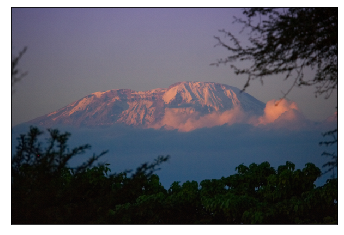

Total loss:  133547720704.0


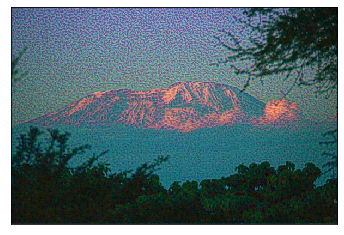

Total loss:  63189155840.0


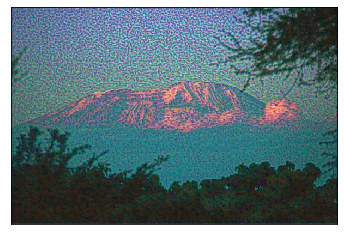

Total loss:  35118616576.0


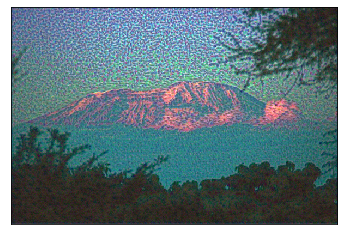

Total loss:  21175644160.0


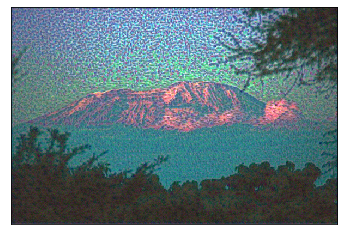

Total loss:  14353684480.0


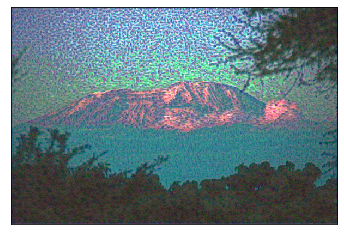

Total loss:  11003677696.0


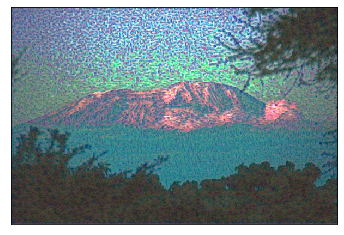

Total loss:  9029705728.0


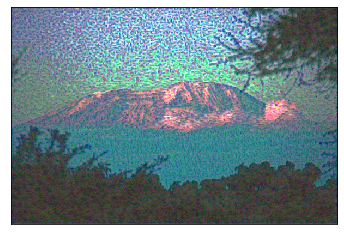

Total loss:  7622786560.0


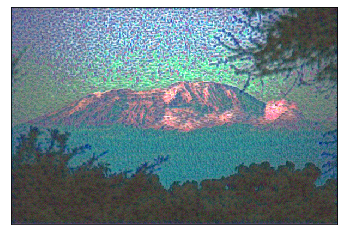

Total loss:  6532894208.0


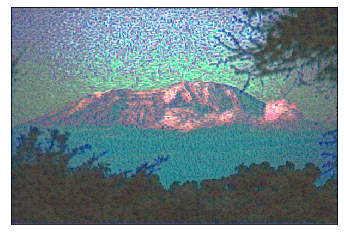

Total loss:  5664465920.0


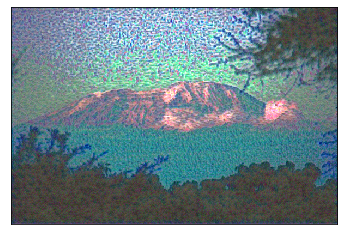

Total loss:  4955039232.0


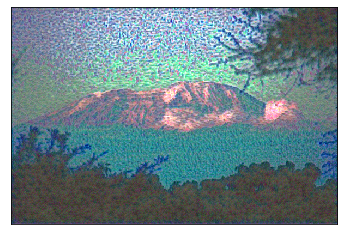

Total loss:  4362680832.0


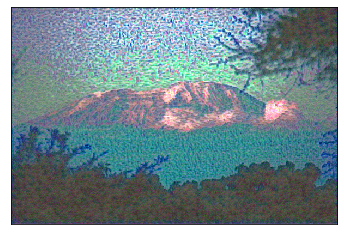

Total loss:  3859399936.0


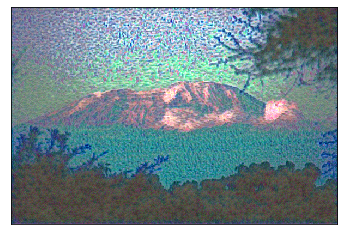

Total loss:  3425551616.0


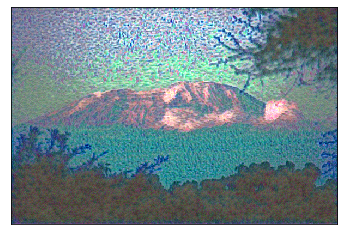

Total loss:  3048203776.0


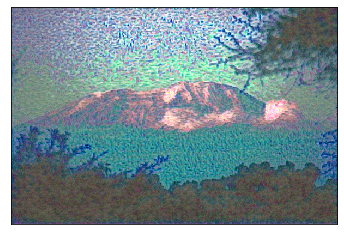

Total loss:  2718569984.0


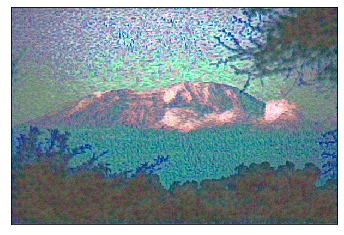

Total loss:  2430193152.0


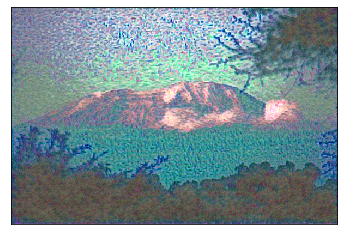

Total loss:  2176826880.0


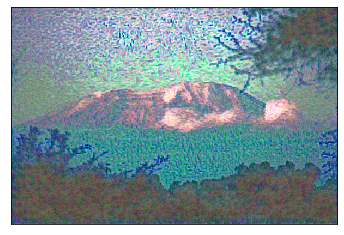

Total loss:  1955242496.0


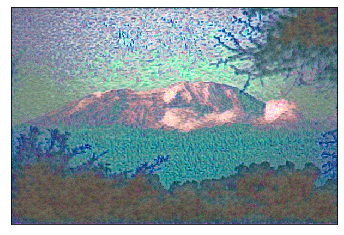

In [25]:
# Define optimizer and link to target image
optimizer = optim.Adam([target], lr=0.005)

# Number of epochs
epochs = 5000

show_every = 250

for epoch in range(epochs):
    
    # Get target features
    target_features = getfeatures(target, vgg, layers)
    
    # Compute content loss
    c_loss = content_loss(target_features, content_features)
    
    # Compute total style loss
    s_loss = style_loss(target_features, style_grams, style_layers_weights)
    
    # Compute total loss (content and style)
    total_loss = loss(c_loss, s_loss, content_weight, style_weight)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Perform backpropagation to compute the gradients w.r.t. the target image
    total_loss.backward()
    
    # Change target image in order to reduce the total loss
    optimizer.step()
    
    # display intermediate images and print the loss
    if  epoch % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(img(target))
        plt.xticks([])
        plt.yticks([])
        plt.show()

### Results

After optimisation we can finally visualize the results of the transfer, alongside with the content image and the style image.

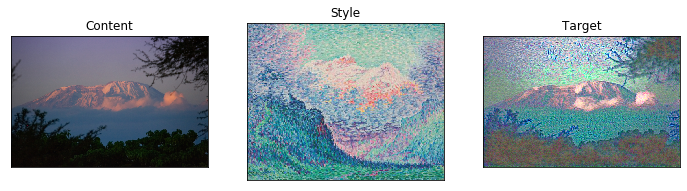

In [26]:
fig = plt.figure(figsize=(12,10))

# Display content image
ax1 = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax1.imshow(img(content))
ax1.set_title("Content")

# Display style image
ax2 = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax2.imshow(img(style))
ax2.set_title("Style")

# Display target image
ax3 = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax3.imshow(img(target))
ax3.set_title("Target")

plt.show()

### Save

Finally we can save out target image:

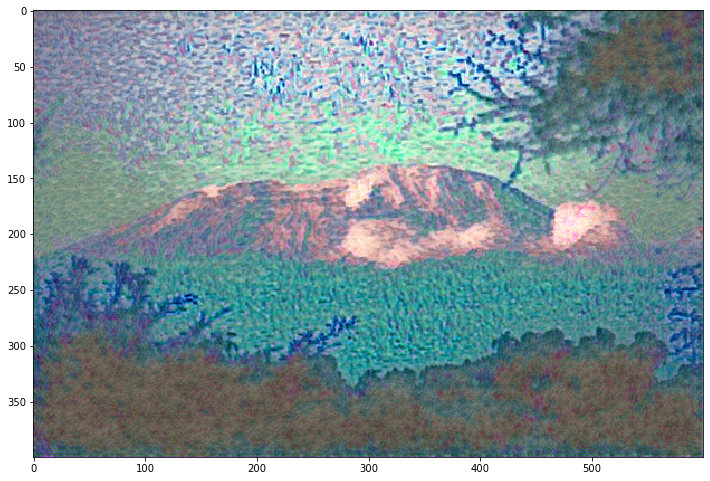

In [27]:
import os

fig = plt.figure(figsize=(12,10))
plt.imshow(img(target))

content_name = os.path.basename(content_path)
style_name = os.path.basename(style_path)

plt.savefig(f"{content_name}+{style_name}.jpg")